# Testing IL
In this notebook we will compare the IL of the implemented AMM to theory.


## Simulation Setup

In [69]:
import sys
import os
import glob
import random
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, value_assets, usd_price, lrna_price
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
# price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.7999},
    'USD': {'usd price': 1, 'weight': 0.20},
    'TKN': {'usd price': 1, 'weight': 0.0001}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            asset_fee=0,
            lrna_fee=0,
            # withdrawal_fee=False
        )
    },
    agents = {
        'LP': Agent(
            holdings={'TKN': 10000},
            trade_strategy=invest_all('omnipool')
        ),
        'Arbitrageur': Agent(
            holdings={tkn: 10000000 for tkn in assets},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool'
            )
        ),
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    archive_all=False
)

In [70]:
steps = 100
price_min = 0.2
price_max = 5
step_factor = (price_max / price_min) ** (1 / (steps - 1))
price_move_range = [price_min * step_factor ** i for i in range(steps)]
price_events = []
# print(price_move_range)

for price in price_move_range:
    price_list = [{'TKN': initial_state.external_market['TKN']}, {'TKN': price}]
    # print(price_list)
    initial_state._evolve_function = historical_prices(price_list)
    # events = run.run(initial_state, 1, silent=True)
    # print(events[-1].external_market)
    price_events.append(run.run(initial_state, 1, silent=True)[-1])
    # price_events[-1].pools['omnipool'].lrna['TKN'] *= price
    # print(price_events[-1].external_market)

<H1>Relationship between IL and price change</H1>
Here we show the impermanent loss incurred as a function of price shift. This graph is somewhat idealized in that TKN is a very small proportion of the pool TVL (0.01%). Because IL is related to the change in TKN/LRNA price, and because the price of LRNA is also responsive to the price of all assets in the pool, a higher proportion of TKN in the pool means a lower rate of IL, especially in a bull-market scenario (because this will tend to increase the proportional weight of TKN).

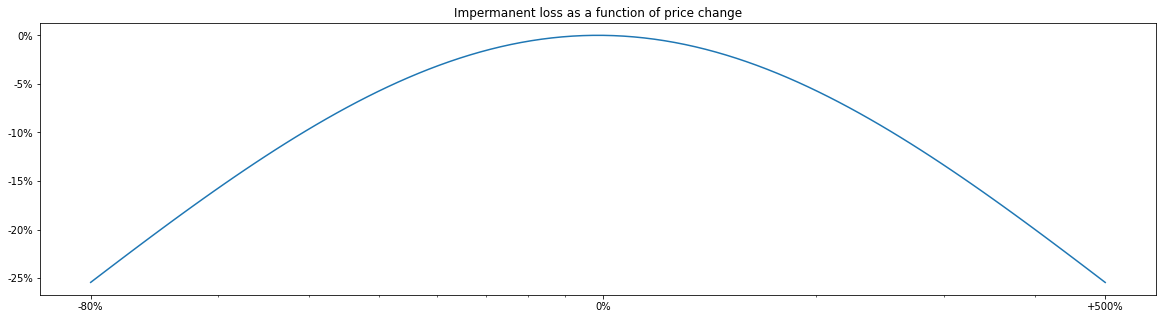

In [94]:
plt.figure(figsize=(20, 5))
plt.title('Impermanent loss as a function of price change')

# plt.yscale('log')
plt.xscale('log')
graph_length = len(price_events)
plt.xticks(
    [price_min, price_move_range[int(graph_length / 2)], price_move_range[graph_length-1]],
    ['-80%', '0%', '+500%']
)
plt.yticks(
    [.75, .80, .85, .90, .95, 1],
    ['-25%', '-20%', '-15%', '-10%', '-5%', '0%']
)
plt.plot(
    price_move_range, 
    [
        cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market)
        / value_assets(initial_state.agents['LP'].holdings, {'TKN': usd_price(event.pools['omnipool'], 'TKN')})
        for event in price_events
    ]
)